In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from circuits_benchmark.utils.get_cases import get_cases
from circuits_benchmark.utils.iit.ll_cfg import make_ll_cfg_for_case

case_name = "20"
case = get_cases(indices=[case_name])[0]

In [3]:
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
import torch

ll_model_loader = get_ll_model_loader(case, interp_bench=True)
hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from typing import Literal

def get_corrupted_thing(
    model,
    data,
    cache_type: Literal["mean", "zero", "resample"] = "mean",
    hook_point: str = "blocks.1.hook_mlp_out",
):
    _, cache = model.run_with_cache(data)
    corrupted_thing = cache[hook_point]
    if cache_type == "mean":
        mean_cache = corrupted_thing.mean(dim = 0)
        # expand to the same shape as corrupted_thing
        mean_cache = mean_cache.expand_as(corrupted_thing)
        return mean_cache
    elif cache_type == "zero":
        return torch.zeros_like(corrupted_thing)
    elif cache_type == "resample":
        # permute the dimensions of corrupted_thing
        idxs = torch.randperm(corrupted_thing.size(0))
        return corrupted_thing[idxs]
    else:
        raise ValueError(f"Unknown cache type: {cache_type}")

In [30]:
from functools import partial


def hook_fn(hook_point_out: torch.Tensor, hook, corrupted_thing: torch.Tensor):
    return corrupted_thing


def get_logits_for_dataset(model, dataset, corrupted_thing):
    hook_point = "blocks.1.hook_mlp_out"
    with torch.no_grad():
        input_tensor = torch.tensor(dataset).to(device="cpu")
        output = model(input_tensor)[:, 1:]
        argmax_idxs = torch.argmax(output, dim=-1)
        ablation_hook = partial(hook_fn, corrupted_thing=corrupted_thing)
        manipulated_output = model.run_with_hooks(
            input_tensor, fwd_hooks=[(hook_point, ablation_hook)]
        )[:, 1:]

        labels = output[
            torch.arange(output.size(0))[:, None],
            torch.arange(output.size(1))[None, :],
            argmax_idxs,
        ]
        manipulated_logit = manipulated_output[
            torch.arange(manipulated_output.size(0))[:, None],
            torch.arange(manipulated_output.size(1))[None, :],
            argmax_idxs,
        ]

        argmax_after_manipulation = torch.argmax(manipulated_output, dim=-1)

    return {
        "labels": labels,
        "manipulated_logit": manipulated_logit,
        "argmax_idxs": argmax_idxs,
        "argmax_after_manipulation": argmax_after_manipulation,
        "output": output,
        "manipulated_output": manipulated_output,
    }


i = case.get_clean_data(max_samples=100000).get_inputs()
corrupted_thing = get_corrupted_thing(model, i, cache_type="resample")
resample_outputs = get_logits_for_dataset(model, i, corrupted_thing)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_81814/2014925109.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(dataset).to(device="cpu")


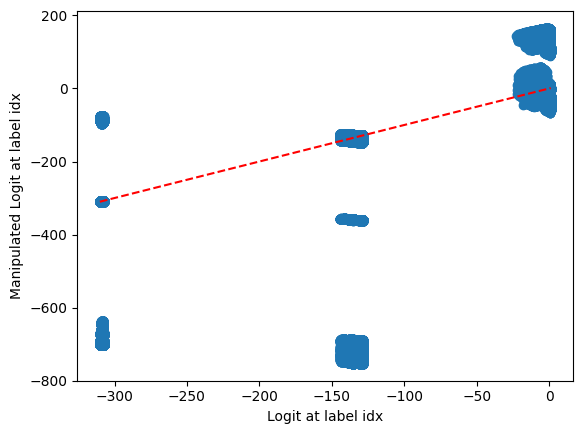

In [15]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.ravel(resample_outputs["labels"].cpu().numpy())
plt.scatter(np.ravel(resample_outputs["labels"].cpu().numpy()), np.ravel(resample_outputs["manipulated_logit"].cpu().numpy()))
plt.xlabel("Logit at label idx")
plt.ylabel("Manipulated Logit at label idx")
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], color='r', linestyle='--')

In [16]:
manipulated_logit = resample_outputs["manipulated_logit"]
labels = resample_outputs["labels"]
argmax_idxs = resample_outputs["argmax_idxs"]
argmax_after_manipulation = resample_outputs["argmax_after_manipulation"]
for idx in range(10):
    print(f'{labels[idx]},\n{manipulated_logit[idx]},\n{argmax_idxs[idx]},\n{argmax_after_manipulation[idx]}') 

tensor([-3.0825e+02,  4.8669e-01, -1.3548e+02, -6.1538e-01,  1.6301e-01,
        -1.3298e+02, -1.3303e+02, -1.3332e+02, -1.3363e+02]),
tensor([-307.9552,    3.2510, -136.3452,  135.2937,  143.9219, -720.5580,
        -137.1535, -137.2515, -718.9747]),
tensor([0, 1, 0, 1, 1, 0, 0, 0, 0]),
tensor([0, 1, 0, 1, 1, 0, 0, 0, 0])
tensor([-3.0825e+02,  7.7891e-01, -1.3565e+02, -3.1764e-01,  2.5353e-01,
        -3.3735e+00, -5.7561e+00, -1.3298e+02, -1.0063e+01]),
tensor([-3.0816e+02, -1.5913e+01, -3.5894e+02, -5.5559e-01,  1.4224e+02,
         1.3940e+02,  5.2534e+00, -7.1976e+02,  1.3440e+02]),
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1]),
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1])
tensor([   0.3455, -137.2612, -138.1825, -137.6952, -136.9572, -136.9725,
        -137.2393, -136.9858, -137.2055]),
tensor([ 6.2865e-01, -1.3722e+02, -1.3708e+02, -7.1939e+02, -7.3372e+02,
        -1.3121e+02, -1.3106e+02, -1.3153e+02, -1.3165e+02]),
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0]),
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(

In [17]:
(~(argmax_after_manipulation == argmax_idxs)).float().mean()

tensor(0.)

### Zero Ablation Effect

In [18]:
corrupted_thing = get_corrupted_thing(model, i, cache_type="zero")
zero_outputs = get_logits_for_dataset(model, i, corrupted_thing)
labels = zero_outputs["labels"]
manipulated_logit = zero_outputs["manipulated_logit"]
argmax_idxs = zero_outputs["argmax_idxs"]
argmax_after_manipulation = zero_outputs["argmax_after_manipulation"]

/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_81814/1307596211.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(dataset).to(device="cpu")


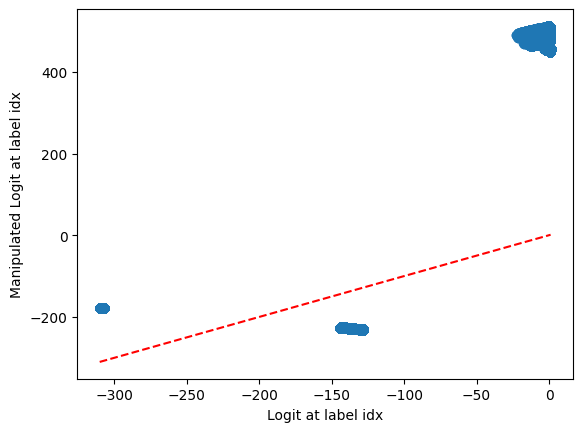

In [19]:
plt.scatter(np.ravel(labels.cpu().numpy()), np.ravel(manipulated_logit.cpu().numpy()))
plt.xlabel("Logit at label idx")
plt.ylabel("Manipulated Logit at label idx")
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], color='r', linestyle='--')

In [20]:
for idx in range(10):
    print(f'{labels[idx]},\n{manipulated_logit[idx]},\n{argmax_idxs[idx]},\n{argmax_after_manipulation[idx]}') 

tensor([-3.0825e+02,  4.8669e-01, -1.3548e+02, -6.1538e-01,  1.6301e-01,
        -1.3298e+02, -1.3303e+02, -1.3332e+02, -1.3363e+02]),
tensor([-177.3976,  486.1591, -228.9359,  485.2714,  495.5654, -229.8769,
        -229.7776, -230.0266, -229.9775]),
tensor([0, 1, 0, 1, 1, 0, 0, 0, 0]),
tensor([0, 1, 0, 1, 1, 0, 0, 0, 0])
tensor([-3.0825e+02,  7.7891e-01, -1.3565e+02, -3.1764e-01,  2.5353e-01,
        -3.3735e+00, -5.7561e+00, -1.3298e+02, -1.0063e+01]),
tensor([-177.3976,  483.6919, -228.4786,  482.8087,  494.6754,  491.4884,
         489.4342, -229.5240,  485.9855]),
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1]),
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1])
tensor([   0.3455, -137.2612, -138.1825, -137.6952, -136.9572, -136.9725,
        -137.2393, -136.9858, -137.2055]),
tensor([ 476.7789, -227.9494, -227.7909, -228.0566, -227.7631, -227.8469,
        -227.5850, -228.0658, -228.0921]),
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0]),
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([-308.5516,    0.4868, -135.4967,   

In [21]:
(~(argmax_after_manipulation == argmax_idxs)).float().mean()

tensor(0.)

### Look at complete outputs

In [24]:
zero_outputs["output"][0, 2], zero_outputs["manipulated_output"][0, 2]

(tensor([-135.4796, -684.5783]), tensor([-228.9359, -332.5369]))